In [ ]:
!pip3 install 'tqdm'

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader
import random
from sklearn.metrics import confusion_matrix 
import seaborn as sn
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [ ]:
if not os.path.isdir('./OpenWorld'):
  !git clone https://github.com/Alessia-Sc/Open-World-Recognition.git OpenWorld

from OpenWorld.CIFAR100 import DatasetCifar100
from OpenWorld.ResNet import resnet32
from tqdm.notebook import tqdm

Cloning into 'OpenWorld'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 147 (delta 86), reused 19 (delta 10), pack-reused 0
Receiving objects: 100% (147/147), 36.63 KiB | 7.33 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
DEVICE="cuda"
TOTAL_CLASSES = 100
NUM_CLASSES = 10

BATCH_SIZE=128
LR=2.0
MOMENTUM=0.9
WEIGHT_DECAY=1e-5

NUM_EPOCHS=70
GAMMA=0.2
MILESTONE=[49,63]

K=2000

In [ ]:
class iCaRLNet(): 
    def __init__(self, feature_size, n_classes, lr=LR, momentum=MOMENTUM, gamma=GAMMA, weight_decay=WEIGHT_DECAY, milestone=MILESTONE, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS):
        # Network architecture
        super(iCaRLNet, self).__init__()
        self.net = resnet32(num_classes=n_classes)
        self.forward = self.net.forward
        self.lr = lr
        self.gamma = gamma
        self.weight_decay = weight_decay
        self.milestone = milestone
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.n_classes = 0
        self.n_known = 0
        self.feature_size=feature_size
        self.momentum=momentum
        self.feature_extractor = self.net.get_feat_ext

        self.loss = nn.BCEWithLogitsLoss()

        self.compute_means = True
        self.exemplar_means = []
        self.exemplar_sets = []
        


    #NME Classification
    def classify(self, x, cif): 
        
        if self.compute_means:
            exemplar_means = []
            #EXEMPLARS
            for P_y in self.exemplar_sets:                          #For each exemplar set
                features = np.zeros((0,self.feature_size))          #Initialization vector of features
                sub = Subset(cif, P_y)                              #Image in current exemplar set
                dl = DataLoader(sub, batch_size=self.batch_size,shuffle=False, num_workers=4) 

                with torch.no_grad():
                    for idx, img, label in dl:                    # Extract feature for each exemplar in P_y
                        img = Variable(img).cuda()
                        feature = self.feature_extractor(img).data.cpu().numpy()
                        feature = normalize(feature, axis=1, norm='l2')
                        features = np.concatenate((features,feature), axis=0) #Estrae tutte le features di tutte le immagini di quella classe

                features = torch.tensor(features)
                mu_y = features.mean(0).squeeze()               #Compute mean of features for the class y
                mu_y.data = mu_y.data / torch.norm(mu_y, p=2)   # L2 Normalize
                exemplar_means.append(mu_y)
                
            self.exemplar_means = exemplar_means 
            self.compute_means = False

        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means)                   #(n_classes, feature_size) Vector of means, for each class
        means = torch.stack([means] * self.batch_size)        #(batch_size, n_classes, feature_size) Expand means as batch size
        means = means.transpose(1, 2)                         #(batch_size, feature_size, n_classes)

        feature = self.feature_extractor(x)          #(batch_size, feature_size) Extraction features for a batch of images
        for i in range(feature.size(0)):             # Normalize
            feature.data[i] = feature.data[i] / torch.norm(feature.data[i], p=2)
        feature = feature.unsqueeze(2)               #(batch_size, feature_size, 1)
        feature = feature.expand_as(means)           #(batch_size, feature_size, n_classes) 
        feature = feature.cuda()
        means = means.cuda()

        #Compute distances between the classes means and each feature vector of each image
        dists = torch.sqrt((feature - means).pow(2).sum(1)).squeeze()  # (batch_size, n_classes)  
        
        #Get the prediction with the class at the minimum distance
        _, preds = dists.min(1) 
        return preds


    def construct_exemplar_set(self, images, m):
        
        features = np.zeros((0,self.feature_size))
        indices = np.zeros((0), dtype=int)
        dl = torch.utils.data.DataLoader(images, batch_size=self.batch_size,shuffle=False, num_workers=4)

        #Extract and normilize the features
        with torch.no_grad():
          for idx, img, label in dl:        #Pick all the image in the dataloader
            x = Variable(img).cuda()
            feature = self.feature_extractor(x).data.cpu().numpy()
            feature = normalize(feature, axis=1, norm='l2')   
            features = np.concatenate((features,feature), axis=0)  
            indices = np.concatenate((indices,idx), axis=0)

        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

        exemplar_set = []
        exemplar_features = np.zeros((0,64))

        for k in range(1, int(m)+1):
            S = np.sum(exemplar_features, axis=0)
            phi = features          
            mu = class_mean         
            mu_p = 1.0 / k * (phi + S)
            mu_p = normalize(mu_p, axis=1, norm='l2')
            i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))  
            exemplar_set.append(indices[i])                   #Pick the image for the exemplar set
            addfeature =  np.expand_dims(features[i], axis=0)
            exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

            #Remove duplicates
            features = np.delete(features, i, 0)
            indices = np.delete(indices, i, 0)
            
        self.exemplar_sets.append(exemplar_set) #Add the set to the existing list of all the exemplar sets
        

    def reduce_exemplar_sets(self, m):
        for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:int(m)]


    def exemplarIndexes(self):
        Indexes = []
        for P_y in self.exemplar_sets:
            Indexes += P_y
        return Indexes


    def update_representation(self, cifar, batchindexes):

        prev_model = copy.deepcopy(self)
        prev_model = prev_model.net.eval().cuda()
        self.net = self.net.cuda()
        self.compute_means = True

        self.n_classes += 10

        # Form combined training set
        newindexes = []
        if self.n_classes > 10:     
            newindexes = self.exemplarIndexes() 
        newindexes += list(batchindexes)
        
        reprdata = Subset(cifar, newindexes)

        loader = DataLoader(reprdata, batch_size=self.batch_size,shuffle=True, num_workers=4, drop_last=True)

        optimizer = optim.SGD(self.net.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestone, gamma=self.gamma)

        for epoch in tqdm(range(self.num_epochs)):
            losses = []
            for _, images, labels in loader:  
                labels = torch.tensor([torch.tensor(train_ds.dict_class_label[c.item()]) for c in labels])
                images = Variable(torch.FloatTensor(images)).cuda()
                labels = Variable(labels).cuda()
                optimizer.zero_grad()
                g = self.forward(images)
                
                y_hot = F.one_hot(labels, self.n_classes).float().cuda()
                
                if self.n_known > 0:
                    q = prev_model.forward(images)
                    q = torch.sigmoid(q)
              
                    #Concatenation of the outputs of the old net + one-hot for new classes
                    target = torch.cat((q[:,:self.n_known], y_hot[:,self.n_known:self.n_classes]), dim=1) 
                    loss = self.loss(g[:,:self.n_classes], target)  
                else:
                    loss = self.loss(g[:,:self.n_classes], y_hot[:,:self.n_classes])  #Classification

                losses.append(loss.item())
                loss.backward()
                optimizer.step()
            
            scheduler.step()    
        

In [ ]:
train_ds = DatasetCifar100(split="train") 
test_ds = DatasetCifar100(split='test')
shuffled_classes = train_ds.classes

def compute_accuracy(dl, icarl):
    y_pred = []
    y_true = []
    total = 0.0
    correct = 0.0
    for _, images, labels in dl: 
        labels = torch.tensor([torch.tensor(train_ds.dict_class_label[c.item()]) for c in labels])

        images = Variable(images).cuda()
        preds = icarl.classify(images, train_ds)

        total = total + len(labels)
        correct += (preds.data.cpu() == labels).sum()

        #Compute prediction and labels vector for the confusion matrix
        preds = preds.detach().cpu().numpy()
        y_pred_tmp = [p for p in preds] 
        y_pred.extend(y_pred_tmp)
        
        labels = labels.detach().cpu().numpy()
        labels = labels.tolist()
        y_true.extend(labels) 
        
    acc = 100 * correct / total
    return acc, y_pred, y_true


Extracting ./CIFAR_100/cifar-100-python.tar.gz to ./CIFAR_100
Files already downloaded and verified


In [ ]:
torch.cuda.current_device()
torch.cuda._initialized = True

icarl = iCaRLNet(64, TOTAL_CLASSES)
icarl.net = icarl.net.to(DEVICE) 
acc_vect = []

for s in range(10):

    print("\n")
    print('-' * 80)
    print(f"ITERATION: {(s+1)*10}/100")

    #Get images of current ten classes  
    print("Loading training examples for classes", shuffled_classes[s*NUM_CLASSES:s*NUM_CLASSES + NUM_CLASSES])
    batchindexes = train_ds.get_indexes_from_labels(shuffled_classes[s*NUM_CLASSES:s*NUM_CLASSES + NUM_CLASSES])
    batch = Subset(train_ds, batchindexes)

    testindexes = test_ds.get_indexes_from_labels(shuffled_classes[0:s*NUM_CLASSES + NUM_CLASSES])
    test_set = Subset(test_ds, testindexes)

    print("Batch size train: {} - Batch size test: {}".format(len(batch), len(test_set)))

    train_loader = DataLoader(batch, batch_size=BATCH_SIZE,shuffle=True, num_workers=4, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=4, drop_last=True) #FALSE

    icarl.net.train()
    icarl.update_representation(train_ds, batchindexes)
    icarl.net.eval()
    m = K / icarl.n_classes 

    icarl.reduce_exemplar_sets(m)

    # Construct exemplar sets for new classes
    for y in shuffled_classes[s*NUM_CLASSES:s*NUM_CLASSES + NUM_CLASSES]:
        imagesInd = train_ds.get_indexes_from_labels([y]) 
        images = Subset(train_ds, imagesInd)
        icarl.construct_exemplar_set(images, m) 

    icarl.n_known = icarl.n_classes
 
    acc, _, _ = compute_accuracy(train_loader, icarl)
    print('Train Accuracy: %.2f' % acc)
        
    acc, test_preds, test_true = compute_accuracy(test_loader, icarl)
    print('Test Accuracy: %.2f' % acc)



--------------------------------------------------------------------------------
ITERATION: 10/100
Loading training examples for classes [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
Batch size train: 5000 - Batch size test: 1000



Train Accuracy: 98.88
Test Accuracy: 91.18


--------------------------------------------------------------------------------
ITERATION: 20/100
Loading training examples for classes [47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
Batch size train: 5000 - Batch size test: 2000



Train Accuracy: 92.15
Test Accuracy: 80.57


--------------------------------------------------------------------------------
ITERATION: 30/100
Loading training examples for classes [81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
Batch size train: 5000 - Batch size test: 3000



Train Accuracy: 91.31
Test Accuracy: 74.52


--------------------------------------------------------------------------------
ITERATION: 40/100
Loading training examples for classes [34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
Batch size train: 5000 - Batch size test: 4000



Train Accuracy: 85.86
Test Accuracy: 66.73


--------------------------------------------------------------------------------
ITERATION: 50/100
Loading training examples for classes [39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
Batch size train: 5000 - Batch size test: 5000



Train Accuracy: 80.79
Test Accuracy: 61.18


--------------------------------------------------------------------------------
ITERATION: 60/100
Loading training examples for classes [30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
Batch size train: 5000 - Batch size test: 6000



Train Accuracy: 85.50
Test Accuracy: 56.76


--------------------------------------------------------------------------------
ITERATION: 70/100
Loading training examples for classes [43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
Batch size train: 5000 - Batch size test: 7000



Train Accuracy: 78.57
Test Accuracy: 51.79


--------------------------------------------------------------------------------
ITERATION: 80/100
Loading training examples for classes [0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
Batch size train: 5000 - Batch size test: 8000



Train Accuracy: 79.15
Test Accuracy: 50.48


--------------------------------------------------------------------------------
ITERATION: 90/100
Loading training examples for classes [45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
Batch size train: 5000 - Batch size test: 9000



Train Accuracy: 77.12
Test Accuracy: 47.77


--------------------------------------------------------------------------------
ITERATION: 100/100
Loading training examples for classes [98, 23, 80, 65, 76, 77, 20, 24, 94, 53]
Batch size train: 5000 - Batch size test: 10000



Train Accuracy: 81.37
Test Accuracy: 46.31


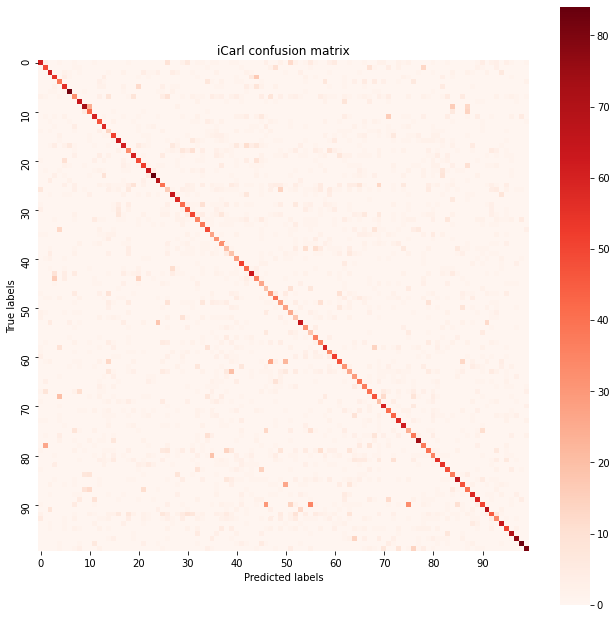

In [ ]:
# Compute and display confusion matrix
acc_matrix = confusion_matrix(test_preds, test_true)
plt.figure(figsize=(11,11))
df_cm = pd.DataFrame(acc_matrix)
sn.heatmap(df_cm, square=True, xticklabels=10, yticklabels=10, cmap='Reds')
plt.title("iCarl confusion matrix")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()